# Notebook Endrix

## Eligibilité aux aides de l'Etat.

Dans un contexte économique marqué par l’incertitude, les pouvoirs publics mettent à disposition plusieurs dispositifs d’aides financières à destination des entreprises. Ces aides visent à soutenir l'activité, encourager l'innovation, compenser certaines charges ou accompagner les plus petites structures dans leur développement.

L’objectif de cette étude est d’identifier, à partir d’un jeu de données simulant les caractéristiques de 100 entreprises, celles qui sont potentiellement éligibles à cinq aides principales :

ACRE (Aide aux Créateurs ou Repreneurs d’Entreprise),

CIR (Crédit d’Impôt Recherche),

Aide Énergie,

Aide Régionale TPE/PME,

Report de Charges Sociales URSSAF.

En croisant différentes variables (ancienneté, effectif, statut juridique, région, dépenses énergétiques, etc.), ce notebook permet de visualiser les entreprises concernées par chaque dispositif et d’en extraire des indicateurs utiles à la décision. L’analyse comprend également une exploration visuelle sous forme de treemap et une synthèse globale de l’éligibilité.
## Etape du projet.

- Importation des librairies nécessaires (numpy, pandas, matplotlib).
- Création du jeu de données (importation durant le stage).
- Description du dataframe obtenue, création de nouvelles variables comme le nombre d'années au sein de l'entreprise et changement de type de données si nécessaires.- 
Statistiques descriptives (indicateurs de position et indicateurs de dipersion)
- Création des critéres d'éligibilité.
- Conclusion.
- Exportation du jeu de données final pour création du dashboard sous Power BI.
  .
### Création du jeu de données fictif
La première étape de ce notebook est de créer le jeu de données de maniére a ce qu'il ressemble le plus possible au jeux de données qui m'a ete confié à partir de portfeuille clients durant mon stage. On va donc commencer par importer toutes les librairies qui nous seront utiles tout au long de cette étude.

In [1]:
import pandas as pd
import numpy as np
import random
!pip install faker
from faker import Faker
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from datetime import datetime
import squarify

Maintenant que toutes nos librairies sont importés on peut passés à la création du jeu de données. Durant mon stage j'ai eu un jeu de données composé de 100 lignes et de 15 colonnes. Dans ces 15 colonnes on retrouve le nom de l'entreprise, la région, le secteur d'activité, son statut, le chiffre d'affaires, les dettes et même le nombre d'employés.

In [3]:
# Initialisation
fake = Faker()
np.random.seed(42)

# Répartition exacte pour 100 entreprises
secteurs = {
    'Santé': 18,
    'Service/Formation': 16,
    'HCR': 12,
    'Sport & Loisirs': 12,
    'Commerce': 10,
    'Bâtiment': 10,
    'Divers': 9,
    'Industrie': 8,
    'Immobilier': 5
}

n = 100  # Nombre total d'entreprises

# Listes de référence
regions = ['Île-de-France', 'Auvergne-Rhône-Alpes', 'Nouvelle-Aquitaine',
           'Occitanie', 'PACA', 'Hauts-de-France']
statuts = ['SARL', 'SAS', 'Auto-entrepreneur', 'SASU', 'SA']
zones = ['ZFU', 'Hors ZFU']

# Création de la colonne Secteur avec la bonne répartition
secteur_labels = []
for secteur, count in secteurs.items():
    secteur_labels.extend([secteur] * count)
np.random.shuffle(secteur_labels)

# Génération des données
data = {
    'Entreprise_ID': [f"E{str(i).zfill(4)}" for i in range(1, n + 1)],
    'Nom_entreprise': [fake.company() for _ in range(n)],
    'Secteur': secteur_labels,
    'Statut': np.random.choice(statuts, size=n),
    'Date_creation': pd.to_datetime(
        np.random.randint(2000, 2024, size=n), format='%Y'
    ) + pd.to_timedelta(np.random.randint(0, 365, size=n), unit='d'),
    'Effectif': np.random.randint(1, 300, size=n),
    'Chiffre_affaires_2023': np.random.uniform(10000, 2_000_000, size=n).round(2),
    'Depenses_energie_2023': np.random.uniform(500, 100_000, size=n).round(2),
    'Depenses_R&D': np.random.choice(
        [0]*70 + list(np.random.uniform(5000, 200_000, size=30)), size=n
    ),
    'Dettes_sociales': np.where(
        np.random.rand(n) < 0.25, 0, np.random.uniform(1000, 150000, size=n).round(2)
    ),
    'Region': np.random.choice(regions, size=n),
    'Zone': np.random.choice(zones, size=n),
    'Baisse_CA_2022_vs_2023': np.random.uniform(-0.5, 0.3, size=n).round(2),
    'Employe_R&D': np.random.choice([0, 1], size=n, p=[0.75, 0.25]),
    'Possede_brevet': np.random.choice([0, 1], size=n, p=[0.9, 0.1])
}

df = pd.DataFrame(data)

# Ajout d'erreurs simulées
for col in ['Chiffre_affaires_2023', 'Depenses_energie_2023', 'Effectif', 'Depenses_R&D']:
    df.loc[df.sample(frac=0.05).index, col] = np.nan

df.loc[df.sample(frac=0.02).index, 'Chiffre_affaires_2023'] = -9999
df.loc[df.sample(frac=0.01).index, 'Effectif'] = 9999

bad_dates = ['2023/15/01', '31-02-2020', 'création inconnue', '25 décembre 2020', np.nan]
bad_date_indices = df.sample(frac=0.02).index
for i in bad_date_indices:
    df.loc[i, 'Date_creation'] = np.random.choice(bad_dates)

df.loc[df.sample(frac=0.01).index, 'Effectif'] = 'inconnu'
df.loc[df.sample(frac=0.01).index, 'Depenses_energie_2023'] = 'absent'
df.loc[df.sample(frac=0.01).index, 'Depenses_R&D'] = 'non disponible'
df.loc[df.sample(frac=0.01).index, 'Employe_R&D'] = 'oui'
df.loc[df.sample(frac=0.01).index, 'Possede_brevet'] = 'non'
df.loc[df.sample(frac=0.01).index, 'Statut'] = 'sarl'
df.loc[df.sample(frac=0.01).index, 'Zone'] = 'Zuf'

# Nettoyage chaînes erronées
df.replace(['inconnu', 'non disponible', 'absent', 'création inconnue'], np.nan, inplace=True)

C:\Users\loris\AppData\Local\Temp\ipykernel_3224\4288678755.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'création inconnue' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[i, 'Date_creation'] = np.random.choice(bad_dates)
C:\Users\loris\AppData\Local\Temp\ipykernel_3224\4288678755.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'inconnu' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df.sample(frac=0.01).index, 'Effectif'] = 'inconnu'
C:\Users\loris\AppData\Local\Temp\ipykernel_3224\4288678755.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'absent' has dtype incompatible with float64, please explicitly cast to a compat

In [5]:
# Visualisation du DataFrame
df.head(10)

,Entreprise_ID,Nom_entreprise,Secteur,Statut,Date_creation,Effectif,Chiffre_affaires_2023,Depenses_energie_2023,Depenses_R&D,Dettes_sociales,Region,Zone,Baisse_CA_2022_vs_2023,Employe_R&D,Possede_brevet
0,E0001,"Hughes, Wilson and Gonzalez",Divers,Auto-entrepreneur,2001-07-14 00:00:00,180.0,NaN,4818.38,0.000000,127121.39,Auvergne-Rhône-Alpes,Hors ZFU,-0.50,1,0
1,E0002,Smith-Reyes,Sport & Loisirs,SARL,2020-05-07 00:00:00,170.0,1314888.04,92502.01,0.000000,0.00,Nouvelle-Aquitaine,ZFU,0.27,0,0
2,E0003,"Lawrence, Boone and Washington",Bâtiment,Auto-entrepreneur,2011-02-02 00:00:00,271.0,776939.28,91952.01,0.000000,60195.81,Hauts-de-France,ZFU,-0.50,1,0
3,E0004,Davis-Espinoza,HCR,Auto-entrepreneur,2005-06-25 00:00:00,54.0,1366411.20,25672.52,0.000000,119797.01,Auvergne-Rhône-Alpes,ZFU,-0.42,0,0
4,E0005,"Horton, Norman and Jennings",HCR,SARL,2022-01-22 00:00:00,101.0,687842.89,69693.41,140817.785914,23337.70,Occitanie,Hors ZFU,-0.25,0,0
5,E0006,Petersen Inc,HCR,Auto-entrepreneur,2003-08-26 00:00:00,NaN,528782.11,8005.74,NaN,0.00,Île-de-France,Hors ZFU,0.15,0,1
6,E0007,Mcmahon-Compton,Service/Formation,SA,2022-06-07 00:00:00,53.0,997114.53,NaN,0.000000,108615.63,Occitanie,Hors ZFU,0.27,0,0
7,E0008,Richards-Drake,Divers,SAS,2010-02-07 00:00:00,60.0,1388851.81,22072.51,0.000000,108285.44,Auvergne-Rhône-Alpes,ZFU,0.13,1,0
8,E0009,Hunter-Hill,Santé,SAS,2023-08-18 00:00:00,108.0,703189.84,29802.15,13942.946949,96531.00,PACA,ZFU,0.05,1,0
9,E0010,Martin Group,Santé,sarl,2016-12-30 00:00:00,5.0,1873929.82,99585.22,140817.785914,104398.32,Île-de-France,Hors ZFU,-0.08,1,0


Le jeu de données étant bien généré avec des erreurs similaires à l'original, je vais maintenant passé à la même analyse statistique que j'ai du réaliser durant le stage.

Les cinq aide de l'Etat qui nous interrresse sont résumés ici :
| Aide de l’État             | Entreprises ciblées                      | Principaux critères d’éligibilité                                                              |
|---------------------------|------------------------------------------|------------------------------------------------------------------------------------------------|
| ACRE (Aide à la Création ou à la Reprise d’Entreprise) | Créateurs ou repreneurs d’entreprise   | Moins de 3 ans d’ancienneté, statut d’auto-entrepreneur ou assimilé, inscription Pôle emploi   |
| CIR (Crédit d’Impôt Recherche)       | Entreprises innovantes de toutes tailles | Dépenses de R&D, présence de personnel dédié, dépôt de brevet, part R&D > 15 % du CA           |
| Aide énergie (bouclier tarifaire)    | Entreprises affectées par la hausse des coûts énergétiques | Dépenses énergie > 3 % du CA, baisse de CA d’au moins 30 %, activité éligible                  |
| Aide régionale PME/TPE               | Petites entreprises selon les régions    | Localisation en région spécifique, nombre d’employés < 250, seuils de CA et indépendance      |
| Report de charges sociales (URSSAF) | TPE/PME en difficulté                   | Baisse significative de chiffre d’affaires, dettes sociales en cours, justification financière |

### Description du DataFrame
Avant de me lancer directement dans une analyse statistique je vais décrire le dataframe pour etre sur d'avoir toutes les valeurs et colonnes et en plus vérifier le format, les valeurs manquantes ou potentiels doublons.

In [7]:
df.shape # Permet d'obtenir la taille du jeu de données

(100, 15)

On constate que le jeu de données est composé de 1000 lignes et 15 colonnes. Nous allons maintenant en faire une copie afin d’éviter toute détérioration en cas de mauvaise manipulation.

In [9]:
df1 = df.copy() # Permet de créer une copie du DataFrame
df1.head(10)

,Entreprise_ID,Nom_entreprise,Secteur,Statut,Date_creation,Effectif,Chiffre_affaires_2023,Depenses_energie_2023,Depenses_R&D,Dettes_sociales,Region,Zone,Baisse_CA_2022_vs_2023,Employe_R&D,Possede_brevet
0,E0001,"Hughes, Wilson and Gonzalez",Divers,Auto-entrepreneur,2001-07-14 00:00:00,180.0,NaN,4818.38,0.000000,127121.39,Auvergne-Rhône-Alpes,Hors ZFU,-0.50,1,0
1,E0002,Smith-Reyes,Sport & Loisirs,SARL,2020-05-07 00:00:00,170.0,1314888.04,92502.01,0.000000,0.00,Nouvelle-Aquitaine,ZFU,0.27,0,0
2,E0003,"Lawrence, Boone and Washington",Bâtiment,Auto-entrepreneur,2011-02-02 00:00:00,271.0,776939.28,91952.01,0.000000,60195.81,Hauts-de-France,ZFU,-0.50,1,0
3,E0004,Davis-Espinoza,HCR,Auto-entrepreneur,2005-06-25 00:00:00,54.0,1366411.20,25672.52,0.000000,119797.01,Auvergne-Rhône-Alpes,ZFU,-0.42,0,0
4,E0005,"Horton, Norman and Jennings",HCR,SARL,2022-01-22 00:00:00,101.0,687842.89,69693.41,140817.785914,23337.70,Occitanie,Hors ZFU,-0.25,0,0
5,E0006,Petersen Inc,HCR,Auto-entrepreneur,2003-08-26 00:00:00,NaN,528782.11,8005.74,NaN,0.00,Île-de-France,Hors ZFU,0.15,0,1
6,E0007,Mcmahon-Compton,Service/Formation,SA,2022-06-07 00:00:00,53.0,997114.53,NaN,0.000000,108615.63,Occitanie,Hors ZFU,0.27,0,0
7,E0008,Richards-Drake,Divers,SAS,2010-02-07 00:00:00,60.0,1388851.81,22072.51,0.000000,108285.44,Auvergne-Rhône-Alpes,ZFU,0.13,1,0
8,E0009,Hunter-Hill,Santé,SAS,2023-08-18 00:00:00,108.0,703189.84,29802.15,13942.946949,96531.00,PACA,ZFU,0.05,1,0
9,E0010,Martin Group,Santé,sarl,2016-12-30 00:00:00,5.0,1873929.82,99585.22,140817.785914,104398.32,Île-de-France,Hors ZFU,-0.08,1,0


On a bien notre copie du jeu de donées, on peut donc vérifier les formats de colonnes, les valeurs manquantes, les doublons. De plus on peut voir que la variable 'Statut' comporte une erreur avec les modalité sarl et SARL qui apparait deux fois. On va commencer par inspecter toutes les modalités des variables qualitatives et ensuite des valeurs manquantes et doublons.

In [11]:
# Changement des modalité de 'Statut' :
## Vérification des modalités :
df1['Statut'].unique()
## Changement de la modalité "sarl" par "SARL":
df1['Statut'] = df1['Statut'].replace({'sarl': 'SARL'})
## Vérification:
df1['Statut'].unique()

# Changement des modalité de 'Secteur' :
## Vérification des modalités :
df1['Secteur'].unique()

# Changement des modalité de 'Zone' :
## Vérification des modalités :
df1['Zone'].unique()
## Changement de la modalité "Zuf" par "ZFU :
df1['Zone'] = df1['Zone'].replace({'Zuf': 'ZFU'})
## Vérification des modalités :
df1['Zone'].unique()

array(['Hors ZFU', 'ZFU'], dtype=object)

Il n'y avait donc deux variables avec des erreur de modalités qui sont probablement des erreurs de frappes. On passe au traitement des formats, valeurs manquantes et doublons.

In [13]:
df1.dtypes # Permet de voir le format de chaque colonne.

Entreprise_ID              object
Nom_entreprise             object
Secteur                    object
Statut                     object
Date_creation              object
Effectif                  float64
Chiffre_affaires_2023     float64
Depenses_energie_2023     float64
Depenses_R&D              float64
Dettes_sociales           float64
Region                     object
Zone                       object
Baisse_CA_2022_vs_2023    float64
Employe_R&D                object
Possede_brevet             object
dtype: object

On remarque que certaines colonnes ne sont pas du bon type comme la colonne "Date_creation" qui devrait etre en DateTime et non object. De plus la variable quantitative "Employe_R&D" et d'autres devraient être au format float et non pas object. Nous allons changer ca et vérifier la bonne modification.

In [15]:
# Changement de type pour la colonne "Date_creation"
df1['Date_creation'] = pd.to_datetime(df1['Date_creation'], errors = 'coerce')

# Changement de type pour la colonne "Employe_R&D"
## Vérification des modalités :
df1['Employe_R&D'].unique()
## Changement de la modalité "oui" par 1:
df1['Employe_R&D'] = df1['Employe_R&D'].replace({'oui': 1,'non': 0})
## Vérification:
df1['Employe_R&D'].unique()
## Changement de type :
df1['Employe_R&D'] = pd.to_numeric(df1['Employe_R&D']).astype('int64')

# Changement de type pour la colonne "Effectif"
## Vérification des modalités :
df1['Effectif'].unique()
## Changement de la modalité "oui" par 1:
df1['Emp'] = df1['Employe_R&D'].replace({'oui': 1,'non': 0})
## Vérification:
df1['Employe_R&D'].unique()
## Changement de type :
df1['Employe_R&D'] = pd.to_numeric(df1['Employe_R&D']).astype('int64')

# Changement de type pour la colonne "Possede_brevet":
## Vérification des modalités :
df1['Possede_brevet'].unique()
## Changement de la modalité "non par 0 :
df1['Possede_brevet'] = df1['Possede_brevet'].replace({'oui': 1, 'non' : 0})
## Vérification :
df1['Possede_brevet'].unique()
## Changement de type :
df1['Possede_brevet'] = df1['Possede_brevet'].astype('category')


C:\Users\loris\AppData\Local\Temp\ipykernel_3224\2976269184.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Employe_R&D'] = df1['Employe_R&D'].replace({'oui': 1,'non': 0})
C:\Users\loris\AppData\Local\Temp\ipykernel_3224\2976269184.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Possede_brevet'] = df1['Possede_brevet'].replace({'oui': 1, 'non' : 0})


In [17]:
df1.dtypes

Entreprise_ID                     object
Nom_entreprise                    object
Secteur                           object
Statut                            object
Date_creation             datetime64[ns]
Effectif                         float64
Chiffre_affaires_2023            float64
Depenses_energie_2023            float64
Depenses_R&D                     float64
Dettes_sociales                  float64
Region                            object
Zone                              object
Baisse_CA_2022_vs_2023           float64
Employe_R&D                        int64
Possede_brevet                  category
Emp                                int64
dtype: object

In [19]:
df1.isna().sum() # Permet d'afficher le total de valeurs manquantes par colonnes

Entreprise_ID             0
Nom_entreprise            0
Secteur                   0
Statut                    0
Date_creation             2
Effectif                  6
Chiffre_affaires_2023     5
Depenses_energie_2023     6
Depenses_R&D              6
Dettes_sociales           0
Region                    0
Zone                      0
Baisse_CA_2022_vs_2023    0
Employe_R&D               0
Possede_brevet            0
Emp                       0
dtype: int64

Dans le jeu de données on observe seulement 4 colonnes comportant des valeurs manquantes. On va regardé à quoi elles correspondent pour les traiter de la meilleure maniére possible.

On sait que chacune des colonnes avec des valeurs manquantes sont nécessaires pour déterminer l'eligibilité a une aide de l'Etat, on va donc observer leur symétrie avec une visualisation de leur distributions.En effet je vais emputer les valeurs manquantes de chaque variable avec la moyenne ou la médian selon leur distributions, si la distribution est symétrique j'imputerai par la moyenne et si c'est asymétrique par la médianne. Pour cela je vais créer une boucle permettant de généré un histogramme par variable.

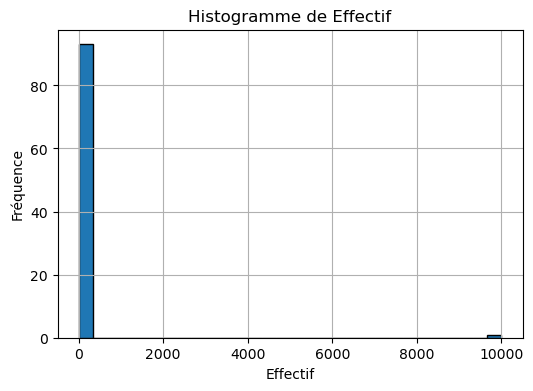

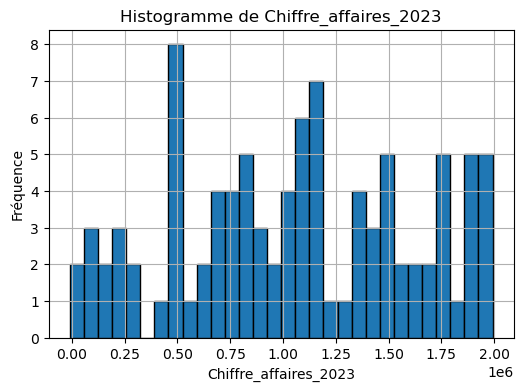

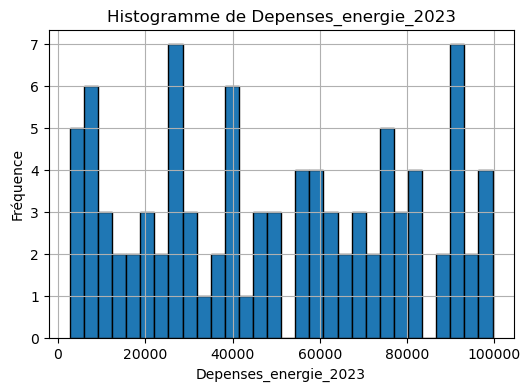

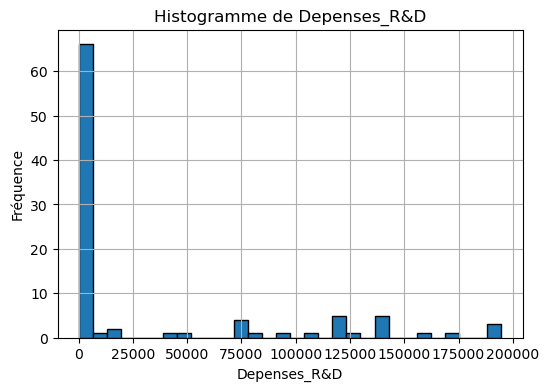

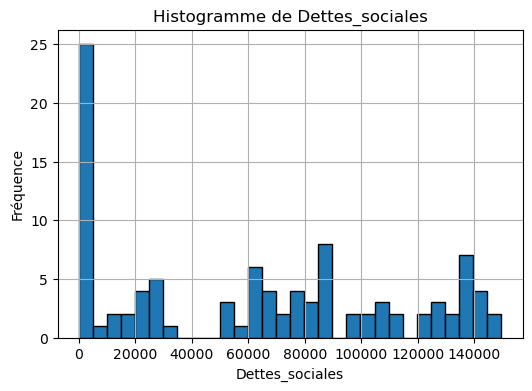

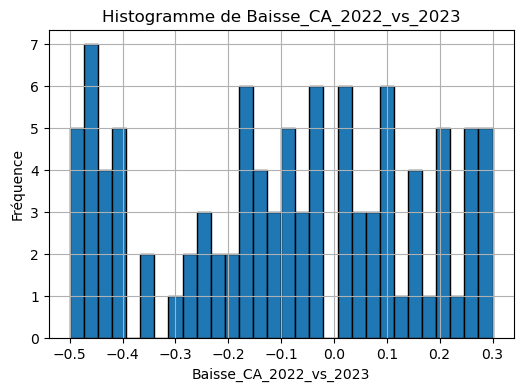

In [21]:
# Création de la variables 'variables' regroupant les variables quantitatives.
variables = df1[['Effectif', 'Chiffre_affaires_2023', 'Depenses_energie_2023', 'Depenses_R&D', 'Dettes_sociales', 'Baisse_CA_2022_vs_2023']]

# Création de la boucle.
for col in variables :
    if col in variables.columns:
        plt.figure(figsize = (6, 4))
        plt.hist(df[col].dropna(), bins = 30, edgecolor = 'black')
        plt.title(f"Histogramme de {col}")
        plt.xlabel(col)
        plt.ylabel("Fréquence")
        plt.grid(True)
        plt.show()

Pour la variable “Effectif”, la distribution est fortement asymétrique avec une concentration de faibles effectifs et quelques valeurs extrêmes très élevées : la médiane est donc préférable à la moyenne pour éviter d’être influencé par ces outliers. De la même façon, le “Chiffre d’affaires 2023” présente une répartition irrégulière et dispersée, ce qui justifie également l’usage de la médiane, en attendant éventuellement une transformation logarithmique pour stabiliser la variance. Les “Dépenses énergie 2023” et “Dépenses R&D” affichent elles aussi une forte asymétrie vers la droite, avec de nombreuses petites valeurs et quelques cas extrêmes ; la médiane reste ici aussi la solution la plus robuste. Concernant les “Dettes sociales”, on observe une accumulation de zéros et une longue traîne de valeurs élevées, confirmant à nouveau le choix de la médiane pour conserver une mesure centrale fiable. Enfin, la variable “Baisse du chiffre d’affaires entre 2022 et 2023” semble quant à elle plus équilibrée et proche d’une distribution symétrique, ce qui autorise l’utilisation de la moyenne comme valeur d’imputation sans risque majeur de biais.

In [23]:
# Imputation par la médiane
df1['Effectif'] = df1['Effectif'].fillna(df1['Effectif'].median())
df1['Chiffre_affaires_2023'] = df1['Chiffre_affaires_2023'].fillna(df1['Chiffre_affaires_2023'].median())
df1['Depenses_energie_2023'] = df1['Depenses_energie_2023'].fillna(df1['Depenses_energie_2023'].median())
df1['Depenses_R&D'] = df1['Depenses_R&D'].fillna(df1['Depenses_R&D'].median())
df1['Dettes_sociales'] = df1['Dettes_sociales'].fillna(df1['Dettes_sociales'].median())

# Imputation par la moyenne (car distribution symétrique)
df1['Baisse_CA_2022_vs_2023'] = df1['Baisse_CA_2022_vs_2023'].fillna(df1['Baisse_CA_2022_vs_2023'].mean())

On va vérifier que l'on a bien imputé les valeurs manquantes par valeur médiane et moyenne.

In [25]:
df1.isna().sum()

Entreprise_ID             0
Nom_entreprise            0
Secteur                   0
Statut                    0
Date_creation             2
Effectif                  0
Chiffre_affaires_2023     0
Depenses_energie_2023     0
Depenses_R&D              0
Dettes_sociales           0
Region                    0
Zone                      0
Baisse_CA_2022_vs_2023    0
Employe_R&D               0
Possede_brevet            0
Emp                       0
dtype: int64

On remarque qu'il reste encore 2 valeurs manquantes dans la vairables 'Date_creation', comme nous n'avons aucun moyen de récuperer ces dates on va supprimer les deux lignes correspondant.

In [29]:
df1 = df1.dropna(subset = ['Date_creation'])

df1.isna().sum()

Entreprise_ID             0
Nom_entreprise            0
Secteur                   0
Statut                    0
Date_creation             0
Effectif                  0
Chiffre_affaires_2023     0
Depenses_energie_2023     0
Depenses_R&D              0
Dettes_sociales           0
Region                    0
Zone                      0
Baisse_CA_2022_vs_2023    0
Employe_R&D               0
Possede_brevet            0
Emp                       0
dtype: int64

Il n'y a plus aucune valeurs manquantes dans notre jeu de données. Je vais maintenant regarder les doublons. 

In [31]:
df1[df1.duplicated()].count() # Permet d'afficher les lignes qui sont exactement les memes par colonnes.

Entreprise_ID             0
Nom_entreprise            0
Secteur                   0
Statut                    0
Date_creation             0
Effectif                  0
Chiffre_affaires_2023     0
Depenses_energie_2023     0
Depenses_R&D              0
Dettes_sociales           0
Region                    0
Zone                      0
Baisse_CA_2022_vs_2023    0
Employe_R&D               0
Possede_brevet            0
Emp                       0
dtype: int64

On remarque qu'il n'y a aucunes valeurs dupliquées qui sont exactement les même dans ce jeu de données. On va voir si le jeu de données comporte des doublons partiels selon l'identifiant de l'entreprise. En effet on veut qu'une ligne unique corresponde à une unique entreprise.

In [33]:
df1[df1.duplicated(subset = 'Entreprise_ID', keep = False)]

,Entreprise_ID,Nom_entreprise,Secteur,Statut,Date_creation,Effectif,Chiffre_affaires_2023,Depenses_energie_2023,Depenses_R&D,Dettes_sociales,Region,Zone,Baisse_CA_2022_vs_2023,Employe_R&D,Possede_brevet,Emp


Comme précédemment on remarque que notre jeu de données ne contient aucun doublons total ou même partiel, on va pouvoir passer à la partie *Analyse statistique*.

### Statistiques Descriptives

Dans cette partie nous allons intéressé aux statistiques descriptives que nous allons séparer en deux parties, l'analyse univariée qui nous donnera des indicateurs statistique concernant sur une seule variable à la fois.

In [35]:
df1.describe(include = ['category', 'number', 'int64']) # Permet de donner un résumé statistique du dataframe, le paramètre include = permet quant à lui de 
# sélectionner le type de format qui sera traiter par le describe

,Effectif,Chiffre_affaires_2023,Depenses_energie_2023,Depenses_R&D,Dettes_sociales,Baisse_CA_2022_vs_2023,Employe_R&D,Possede_brevet,Emp
count,98.000000,9.800000e+01,98.000000,98.000000,98.000000,98.000000,98.000000,98.0,98.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN
mean,254.571429,1.054673e+06,49620.803316,29629.453416,62288.183980,-0.097551,0.326531,NaN,0.326531
std,998.060583,5.457052e+05,29046.219578,55804.107481,50318.517612,0.243400,0.471355,NaN,0.471355
min,1.000000,-9.999000e+03,2707.380000,0.000000,0.000000,-0.500000,0.000000,NaN,0.000000
25%,94.500000,6.916796e+05,25845.642500,0.000000,7532.072500,-0.280000,0.000000,NaN,0.000000
50%,153.000000,1.073312e+06,48280.695000,0.000000,65046.770000,-0.080000,0.000000,NaN,0.000000
75%,238.750000,1.480989e+06,74772.660000,13942.946949,103265.507500,0.090000,1.000000,NaN,1.000000


Le tableau ci-dessus présente les statistiques descriptives de base telles que la moyenne, l’écart-type, les valeurs minimales et maximales, ainsi que d’autres indicateurs utiles pour obtenir une première vue d’ensemble des entreprises.

##### Variables quantitatives continues:

* _Chiffre_affaires_2023 :_ Le chiffre d’affaires moyen est de 1 054 673 €, avec une médiane légèrement supérieure (1 073 312 €), ce qui montre une distribution relativement équilibrée. Cependant, la présence d’une valeur minimale à -9999 € (valeur aberrante) rend nécessaire un nettoyage préalable. L’écart-type élevé (5,45 M€) indique une grande variabilité entre les entreprises.

* _Dépenses_énergie_2023 :_ Les dépenses en énergie s’élèvent en moyenne à 49 620 €, avec une médiane proche (48 280 €), ce qui suggère une distribution plutôt symétrique. La valeur maximale dépasse 99 000 €, mais aucune valeur ne semble manifestement aberrante. Cette variable paraît exploitable sans transformation majeure.

* _Dépenses_R&D :_ La moyenne des dépenses en R&D est de 29 629 €, mais la médiane est de 0 €, ce qui signifie que plus de la moitié des entreprises ne dépensent rien en R&D. On observe cependant des valeurs très élevées (jusqu’à 194 756 €), signe d’une répartition très asymétrique, avec quelques entreprises très investies dans ce domaine. Ces valeurs pourraient être croisées avec la présence d’un employé R&D ou la possession d’un brevet.

* _Dettes_sociales :_ Les dettes sociales moyennes sont de 62 288 €, avec une médiane légèrement supérieure (65 046 €). La distribution est globalement symétrique, mais il existe des entreprises sans dette (valeur minimale à 0). Cette variable est intéressante pour analyser la santé financière, bien qu’elle soit sujette à quelques outliers modérés.

* _Baisse_CA_2022_vs_2023 :_ Cette variable mesure l’évolution du chiffre d’affaires : la moyenne indique une baisse moyenne de 9,7 %, avec une médiane à -8 %, ce qui montre que la majorité des entreprises ont subi un recul. Les extrêmes vont de -50 % à +30 %, ce qui reste plausible. La distribution est exploitable telle quelle, sans nettoyage.

##### Variable quantitative discrétes :

* _Effectif :_ L’effectif moyen des entreprises est de 254 employés, mais l’écart-type très élevé (998) et la valeur maximale de 9999 révèlent une forte dispersion. La médiane étant de 153, on observe une asymétrie à droite : une minorité d'entreprises possède un nombre très élevé d'employés, ce qui fausse la moyenne. Des valeurs aberrantes sont probablement présentes.

* _Employe_R&D :_  Cette variable binaire indique que 32,6 % des entreprises ont au moins un employé affecté à la R&D. Ce taux permet de caractériser le dynamisme technologique des structures. Elle est bien formatée et directement exploitable dans les analyses croisées.

* _Possede_brevet :_ Cette autre variable binaire montre que 47 % des entreprises déclarent posséder un brevet. Cela en fait un indicateur pertinent à relier aux dépenses R&D ou à l’emploi d’un personnel dédié. Sa répartition est équilibrée et son format est adapté à l’analyse.

Ce résumé statistique nous a donc permit de mieux comprendre le jeu de données que nous avons à notre disposition. On va regarder la distribution des variables catégorielles comme 'Statut', 'Secteur' etc.

##### Répartition des entreprises par statut 

['Auto-entrepreneur' 'SARL' 'SA' 'SAS' 'SASU']


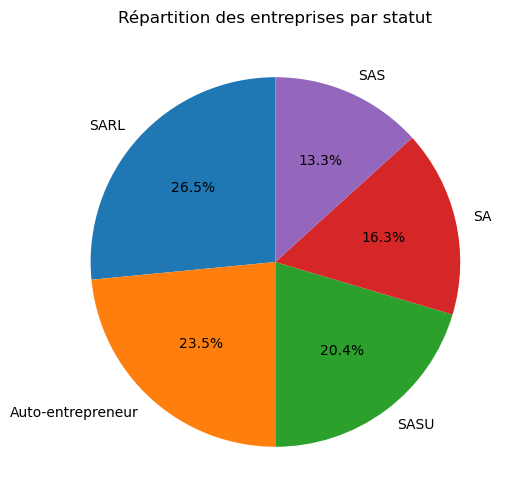

In [37]:
# Diagramme Circulaire de la variable 'Statut':

    # Vérification des modalités :
print(df1['Statut'].unique())
    # Création des fréquences selon les modalités :
statut_count = df1['Statut'].value_counts()
statut_count
    # Création du diagramme circulaire :
plt.figure(figsize = (6,6)) # Permet de modifier la taille de la figure
plt.pie(statut_count, labels = statut_count.index, autopct ='%1.1f%%', startangle = 90) # Sélection des fréquences, affichage des pourcentages 
# et commencer à 90°
plt.title('Répartition des entreprises par statut') # Rajout de titre
plt.show()

Ce diagramme circulaire met en évidence la répartition des entreprises selon leur statut juridique. On observe que la forme la plus courante est celle de la SARL (Société à Responsabilité Limitée), qui représente 26,5 % des entreprises. Ce statut est souvent privilégié pour sa souplesse de fonctionnement et la limitation de responsabilité des associés, ce qui en fait une structure adaptée aux petites et moyennes entreprises. En deuxième position, les auto-entrepreneurs représentent 23,5 % de l’échantillon, soulignant une forte présence d’activités individuelles, typiques des freelances ou des professionnels en activité indépendante.

Les SASU (Sociétés par Actions Simplifiées Unipersonnelles) regroupent 20,4 % des entreprises. Ce statut, très utilisé par les créateurs d’entreprises souhaitant évoluer vers une structure plus développée, permet une grande flexibilité de gestion tout en gardant une responsabilité limitée. Viennent ensuite les SA (Sociétés Anonymes) avec 16,3 %, qui sont des formes juridiques plus complexes, souvent réservées aux grandes structures disposant d’un capital social important. Enfin, les SAS (Sociétés par Actions Simplifiées) ne représentent que 13,3 %, ce qui peut s’expliquer par le fait que ce statut, bien qu’en forte croissance en France, reste encore moins représenté dans cet échantillon particulier.

Globalement, cette répartition montre une nette dominance des statuts juridiques souples et accessibles, adaptés à des structures entrepreneuriales de taille réduite, en phase de croissance ou à vocation indépendante.

##### Répartition des entreprise par Zone 

['Auvergne-Rhône-Alpes' 'Nouvelle-Aquitaine' 'Hauts-de-France' 'Occitanie'
 'Île-de-France' 'PACA']


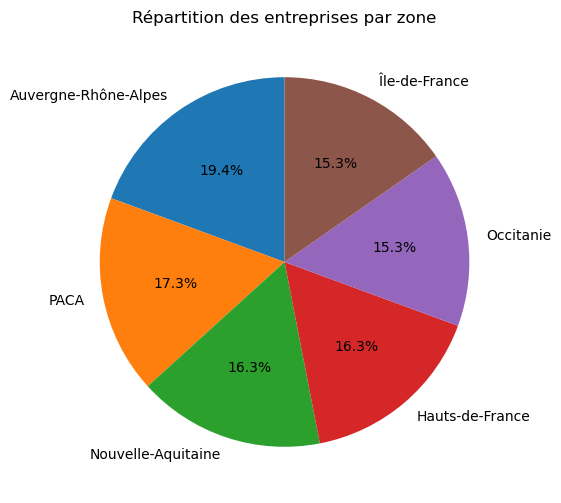

In [39]:
# Diagramme Circulaire de la variable 'Zone':

    # Vérification des modalités :
print(df1['Region'].unique())
    # Création des fréquences selon les modalités :
region_count = df1['Region'].value_counts()
region_count
    # Création du diagramme circulaire :
plt.figure(figsize = (6,6)) # Permet de modifier la taille de la figure
plt.pie(region_count, labels = region_count.index, autopct ='%1.1f%%', startangle = 90) # Sélection des fréquences, affichage des pourcentages 
# et commencer à 90°
plt.title('Répartition des entreprises par zone') # Rajout de titre
plt.show()

Ce diagramme circulaire illustre la répartition géographique des entreprises selon six grandes régions françaises. Voici ce que l'on peut en tirer :

- Auvergne-Rhône-Alpes est la région la plus représentée, avec 19,4 % des entreprises. Cela suggère une forte activité économique ou un tissu entrepreneurial dense dans cette zone.

- La région PACA (Provence-Alpes-Côte d’Azur) suit avec 17,3 %, ce qui est cohérent avec la présence d’un tissu économique varié, notamment dans les services et le tourisme.

- Nouvelle-Aquitaine et Hauts-de-France comptent chacune 16,3 % des entreprises, ce qui traduit une représentativité stable dans ces régions.

- Île-de-France et Occitanie ferment la marche avec 15,3 % chacune. Cela peut être surprenant pour l’Île-de-France, souvent vue comme moteur économique, mais cela peut s’expliquer par des biais d’échantillonnage ou une concentration moindre dans certaines activités.

#### Analyse bivariée
Cette partie va nous permettre de réellement voir les liens entre les variables pour déterminer ce qui influe sur la performance des employés et détecter des facteurs d'améliorations.
##### Matrice de dispersion
Cette matrice va nous permettre d'observer les relations entre chaque variables via un nuage de points et histogramme pour les relations entre la même variable.

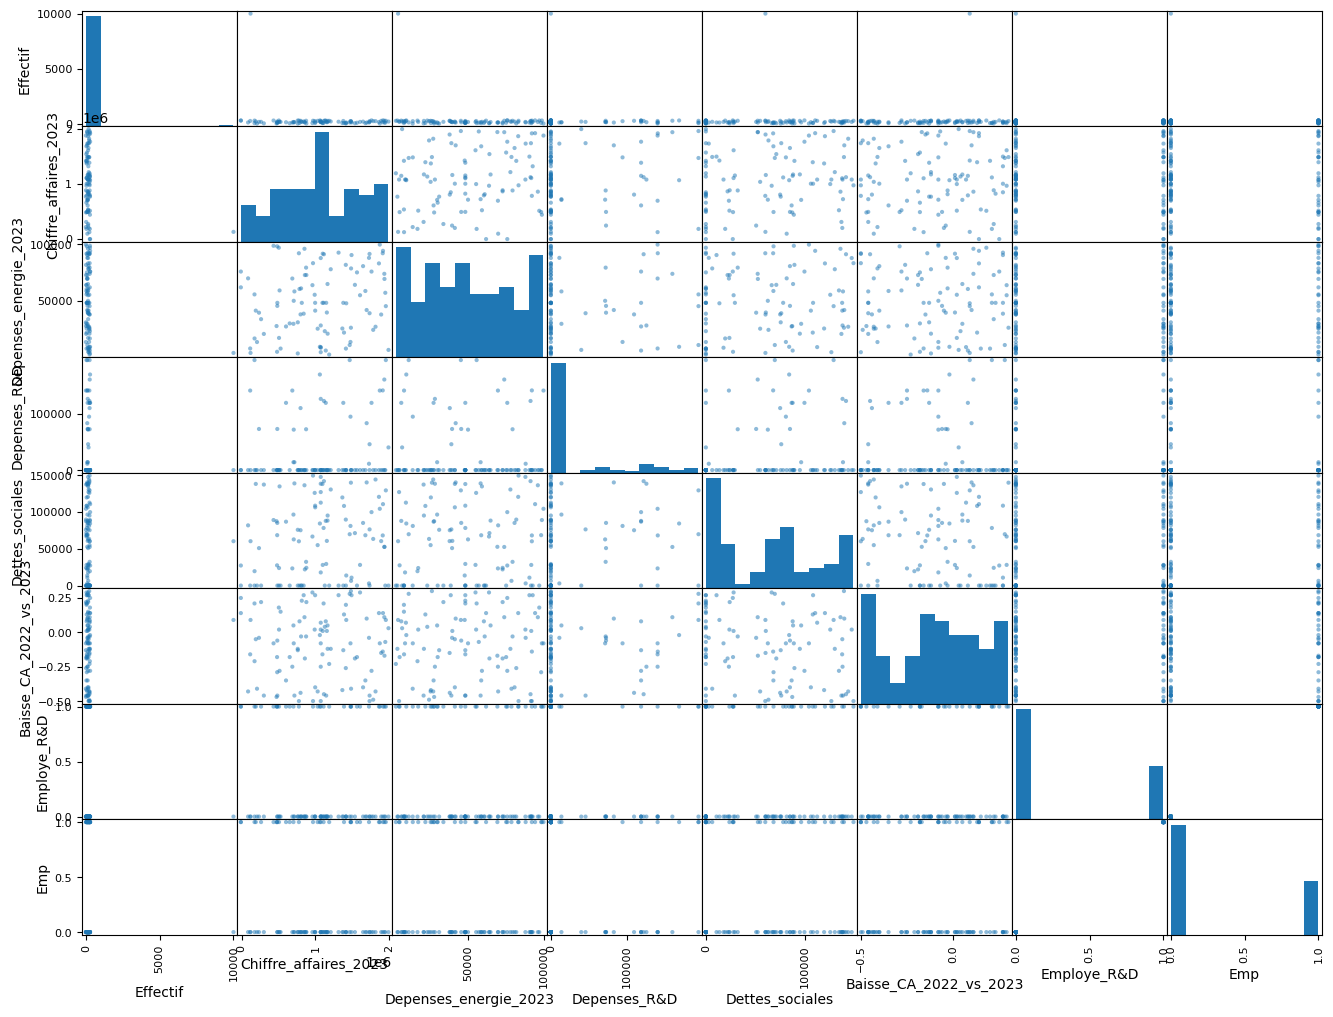

In [41]:
scatter_matrix(df1, figsize = (16, 12))
plt.show()

La matrice de dispersion permet d’explorer visuellement les relations entre les variables quantitatives du jeu de données. Elle met en évidence plusieurs éléments importants. Tout d’abord, les distributions en diagonale révèlent des variables très asymétriques, notamment l’effectif et le chiffre d’affaires 2023, où l’on observe la présence de valeurs extrêmes (outliers) pouvant fortement influencer les analyses statistiques. Les variables dépenses énergie et dépenses R&D montrent également une forte hétérogénéité, avec une concentration autour de faibles valeurs et quelques cas de dépenses très élevées. Concernant les relations entre variables, on note une légère corrélation positive entre le chiffre d’affaires et les dépenses R&D ou énergie, ce qui est logique pour des entreprises plus grandes ou plus performantes. En revanche, aucune relation claire ne se dégage entre les dettes sociales ou la baisse du chiffre d’affaires et les autres indicateurs, suggérant une influence multifactorielle. Enfin, les variables binaires Employé R&D et Emp se présentent sous forme de bandes verticales et ne montrent de lien visuel que sur les cas où des dépenses R&D sont enregistrées. Ce graphique met donc en lumière la nécessité d’un nettoyage et d’une analyse plus approfondie pour traiter les extrêmes et valider statistiquement les tendances observées.

##### Relation entre le chiffre d'affaire et la région 

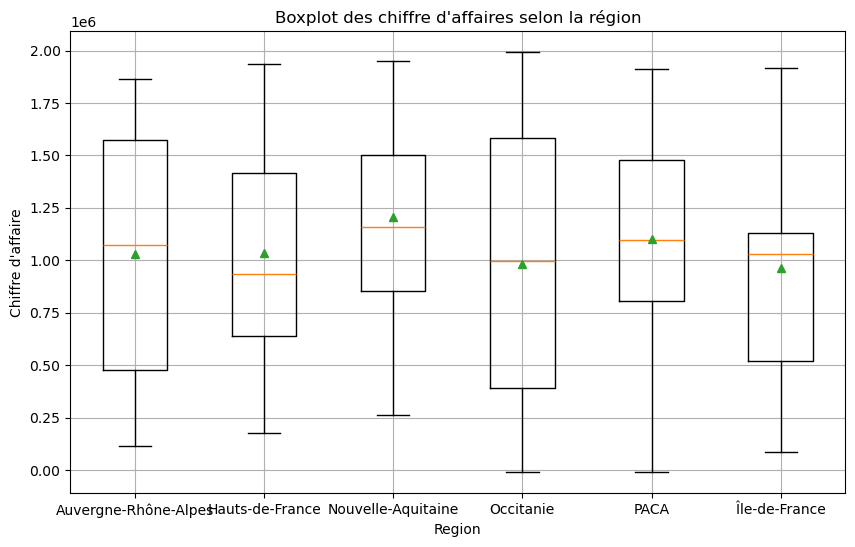

In [47]:
# Création du boxplot :
ca_zone = df1.groupby('Region')['Chiffre_affaires_2023'].apply(list)

plt.figure(figsize = (10, 6))
plt.boxplot(ca_zone, labels = ca_zone.index, showmeans = True)
plt.title("Boxplot des chiffre d'affaires selon la région")
plt.xlabel("Region")
plt.ylabel("Chiffre d'affaire")
plt.grid(True)
plt.show()

Ce boxplot compare les chiffres d'affaires des entreprises selon leur région. On observe que la médiane (trait orange) et la moyenne (triangle vert) varient sensiblement entre les régions. Par exemple, Nouvelle-Aquitaine et PACA présentent les chiffres d'affaires moyens les plus élevés, tandis que Île-de-France et Occitanie ont des distributions plus concentrées autour de valeurs médianes inférieures. Certaines régions comme Occitanie ou Auvergne-Rhône-Alpes présentent une forte dispersion, indiquant une grande hétérogénéité des entreprises, avec des cas extrêmes (outliers) très élevés ou très bas. Ce graphique souligne des disparités économiques régionales significatives.

### Création des critères d'éligibilité

#### Aide ACRE (Aide à la création d'entreprise)

Nous allons maintenant nous intéresser à la première aide de notre étude c'est-à-dire l'aide ACRE (Aide à la Création ou à la Reprise d’Entreprise). Cette aide est destinée aux créateurs ou repreneurs récents d’entreprise, en particulier les auto-entrepreneurs inscrits à Pôle emploi depuis moins de 3 ans. On va donc créer la variable "Anciennete" et regarder l'éligibilité des entreprises.

In [49]:
# Création de la colonne "Anciennete"
df1['Anciennete'] = datetime.now().year - pd.to_datetime(df1['Date_creation'], errors = 'coerce').dt.year

# Détection des entreprises éligibles à l'ACRE
df1['Aide_ACRE'] = (
    (df1['Anciennete'] <= 3) &
    (df1['Statut'].str.lower().str.strip() == 'auto-entrepreneur')
)

# Nombre d'entrerpise éligible à l'ACRE :
nb_acre = df1['Aide_ACRE'].sum()
print("Nombre d'entreprises éligibles à l'ACRE :", nb_acre)

Nombre d'entreprises éligibles à l'ACRE : 1


La premiére aide est seulement disponible pour une unique entreprise. 

#### Aide CIR (Crédit d'impot Recherche)

Cette seconde aide s’adresse aux entreprises investissant dans la R&D, avec un personnel dédié, des dépenses élevées (plus de 15 % du chiffre d'affaires) et souvent un dépôt de brevet.

In [51]:
df1['Part_RD'] = df1['Depenses_R&D'] / df['Chiffre_affaires_2023']

df1['Aide_CIR'] = (
    (df1['Depenses_R&D'] > 0) &
    ((df1['Employe_R&D'] == 1) | (df['Possede_brevet'] == 1)) &
    (df1['Part_RD'] > 0.15)
)

# Comptage des entrerpises éligibles à la CIR :
nb_cir = df1['Aide_CIR'].sum()
print("Nomvre d'entreprise éligibles à la CIR :", nb_cir)

Nomvre d'entreprise éligibles à la CIR : 4


Parmis les 100 entreprises du cabinet seulement 4 d'entre elles peuvent bénéficier de la CIR

#### Aide énergie (Bouclier tarifaire)

Le Bouclier tarifaire quant à lui vise les entreprises fortement impactées par la hausse des prix de l’énergie, cumulant une part énergétique > 3 % du CA, une baisse d’activité ≥ 30 % et un secteur éligible.

In [53]:
df1['Part_Energie'] = df1['Depenses_energie_2023'] / df['Chiffre_affaires_2023']

df1['Aide_Energie'] = (
    (df1['Part_Energie'] > 0.03) &
    (df1['Baisse_CA_2022_vs_2023'] <= -0.30) &
    (df1['Secteur'] != 'Immobilier')
)

# Nombre d'entrerpise éligible à l'aide energie :
nb_aide_energie = df1['Aide_Energie'].sum()
print("Nombre d'entreprises éligibles à l'Aide Energie :", nb_aide_energie)

Nombre d'entreprises éligibles à l'Aide Energie : 17


L'aide Energie peut être demandé par 17 entreprises.

#### Aide régionale TPE/PME

L'avant dernière aide est variable selon les régions, cette aide concerne les petites structures indépendantes de moins de 250 salariés et répondant à des seuils de CA spécifiques.

In [55]:
df1['Aide_Regionale'] = (
    (df1['Effectif'] < 250) &
    (df1['Statut'] != 'SA') &
    (df1['Region'].isin(['PACA', 'Occitanie']))
)

# Nombre d'entrerpise éligible à l'aide régionale TPE/PME :
nb_aide_region = df1['Aide_Regionale'].sum()
print("Nombre d'entreprises éligibles à l'aide Régionale TPE/PME :", nb_aide_region)

Nombre d'entreprises éligibles à l'aide Régionale TPE/PME : 21


Comme l'Aide Energie 21 entreprises sont éligibles à l'Aide Régional

#### Report de charges sociales (URSSAF)

Le report de charges sociales est seulement accordé aux entreprises en difficulté justifiant d’une forte baisse de chiffre d’affaires et de dettes sociales existantes.

In [57]:
df1['Aide_URSSAF'] = (
    (df1['Baisse_CA_2022_vs_2023'] <= -0.20) &
    (df1['Dettes_sociales'] > 0)
)

# Nombre d'entrerpise éligible au report de charges sociales :
nb_aide_urssaf = df1['Aide_URSSAF'].sum()
print("Nombre d'entreprises éligibles à l'aide URSSAF :", nb_aide_urssaf)

Nombre d'entreprises éligibles à l'aide URSSAF : 27


Le report de charge sociales est l'aide pouvant etre la plus demandées avec 27 elibigilitées. On va visualiser le nombre d'entreprises qui peuvent bénéficier d'une seule aide.

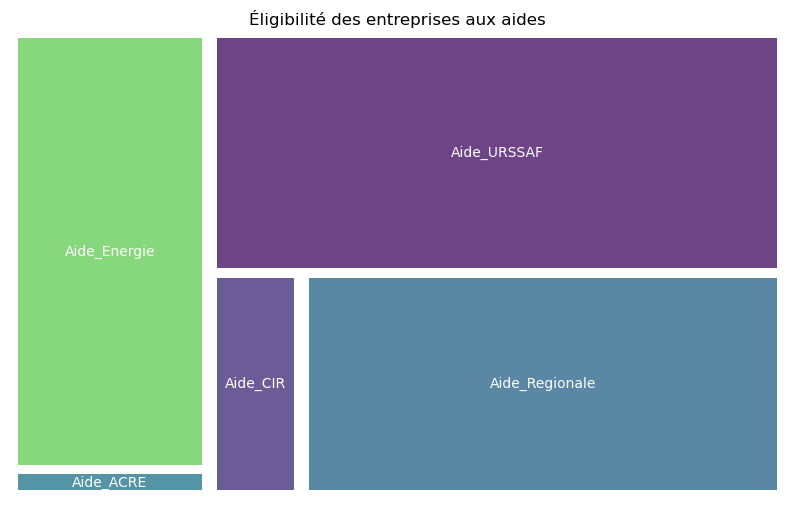

In [59]:
aides = ['Aide_ACRE', 'Aide_Energie', 'Aide_CIR', 'Aide_Regionale', 'Aide_URSSAF']
frequences = {aide: df1[aide].sum() for aide in aides}

labels = list(frequences.keys())
sizes = list(frequences.values())

# Affichage du treemap
plt.figure(figsize = (10, 6))
squarify.plot(sizes = sizes, pad = 0.2, text_kwargs = {'fontsize': 10, 'color': 'white'}, label = labels, alpha=0.8)
plt.title('Éligibilité des entreprises aux aides')
plt.axis('off')
plt.show()

Ce treemap illustre la répartition des entreprises éligibles à différentes aides publiques. On constate que l'Aide_URSSAF est la plus fréquente, suivie de l'Aide_Energie et de l'Aide_Regionale, ce qui indique que ces dispositifs sont les plus accessibles ou concernent le plus grand nombre d'entreprises. En revanche, l'Aide_CIR (Crédit Impôt Recherche) et surtout l'Aide_ACRE, très spécifiques (notamment réservée aux auto-entrepreneurs récents), concernent beaucoup moins d'entreprises. Cette visualisation met en évidence la portée variable de chaque aide selon ses critères d’éligibilité.

#### Visulation des répartitions des aides 

Dans cette partie on va s'interresser aux entreprises qui peuvent bénéficier de plusieurs aides à la fois et enfin leur répartition.

In [71]:
# Création de la variable aide pour déterminer le nombre d'aides disponibles par entreprises :
aides = df1[['Aide_ACRE', 'Aide_Energie', 'Aide_CIR', 'Aide_Regionale', 'Aide_URSSAF']]

df1['Nombre_Aides'] = df1[aides].sum(axis = 1) 
entreprises_aides = df1[df1['Nombre_Aides'] > 1]

print("Entreprises avec plusieurs aides :", len(entreprises_aides))
entreprises_aides

Entreprises avec plusieurs aides : 18


,Entreprise_ID,Nom_entreprise,Secteur,Statut,Date_creation,Effectif,Chiffre_affaires_2023,Depenses_energie_2023,Depenses_R&D,Dettes_sociales,...,Emp,Anciennete,Aide_ACRE,Part_RD,Aide_CIR,Part_Energie,Aide_Energie,Aide_Regionale,Aide_URSSAF,Nombre_Aides
2,E0003,"Lawrence, Boone and Washington",Bâtiment,Auto-entrepreneur,2011-02-02,271.0,776939.28,91952.010,0.000000,60195.81,...,1,14,False,0.000000,False,0.118352,True,False,True,2
4,E0005,"Horton, Norman and Jennings",HCR,SARL,2022-01-22,101.0,687842.89,69693.410,140817.785914,23337.70,...,0,3,False,0.204724,False,0.101322,False,True,True,2
10,E0011,Hall-Gallagher,Service/Formation,SASU,2005-02-20,103.0,87980.79,69844.040,0.000000,81865.94,...,0,20,False,0.000000,False,0.793856,True,False,True,2
28,E0029,Jones-Hernandez,Santé,SARL,2002-08-08,127.0,1073311.67,28336.470,126057.108462,138452.41,...,0,23,False,0.117447,False,0.026401,False,True,True,2
29,E0030,"Patterson, Macias and Gray",Bâtiment,SAS,2018-06-07,129.0,998156.77,41415.070,0.000000,106378.56,...,0,7,False,0.000000,False,0.041492,True,False,True,2
31,E0032,Carey and Sons,Sport & Loisirs,SASU,2006-01-06,122.0,602294.00,27460.290,119029.390660,86866.97,...,1,19,False,0.197627,True,0.045593,True,False,True,3
36,E0037,Kelly-Riley,Commerce,SA,2006-12-15,126.0,716261.33,58325.680,13942.946949,138909.71,...,0,19,False,0.019466,False,0.081431,True,False,True,2
59,E0060,Peterson-Ward,Industrie,SASU,2002-10-15,218.0,1735068.72,91359.990,0.000000,0.00,...,0,23,False,0.000000,False,0.052655,True,True,False,2
60,E0061,James PLC,Sport & Loisirs,SARL,2018-12-08,39.0,1678576.72,58722.380,0.000000,68413.49,...,0,7,False,0.000000,False,0.034983,True,True,True,3
63,E0064,"Mclaughlin, Burns and Montoya",HCR,SARL,2002-06-04,254.0,799336.69,38096.130,109766.366259,75256.80,...,0,23,False,0.137322,False,0.047660,True,False,True,2


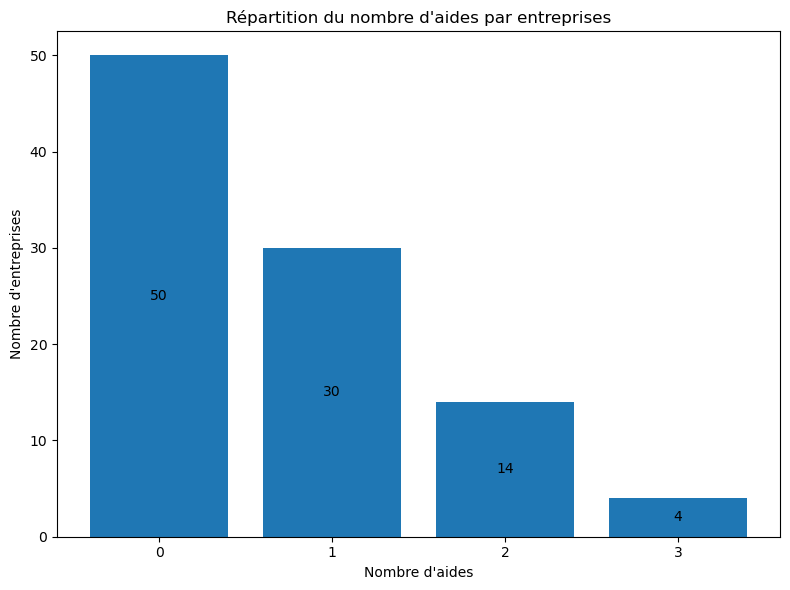

In [75]:
# Création des fréquences :
count_aides_entreprises = df1['Nombre_Aides'].value_counts().sort_index()

# Création du diagramme en barres :
plt.figure(figsize=(8, 6))
bars = plt.bar(count_aides_entreprises.index.astype(str), count_aides_entreprises.values)
plt.title("Répartition du nombre d'aides par entreprises")
plt.xlabel("Nombre d'aides")
plt.ylabel("Nombre d'entreprises")

# Ajout des étiquettes au centre des barres :
for bar in bars:
    height = bar.get_height() # Permet de récupérer la hauteur de chaque barre
    plt.text(bar.get_x() + bar.get_width() / 2, # .get_x() donne la position de la barre, bar.get_width() / 2 permet de centrer le texte
             height / 2, # Permet de placer l'étiquette au milieu de la barre.
             f'{int(height)}',
             ha = 'center', va = 'center', color = 'black', fontsize=10)

plt.tight_layout()
plt.show()

Ce graphique en barres illustre la répartition du nombre d'aides reçues par les entreprises. On observe que la majorité des entreprises (50) n’ont reçu aucune aide, tandis que 30 en ont reçu une seule, 14 en ont bénéficié de deux, et seulement 4 ont eu accès à trois aides. Cette distribution met en évidence un accès relativement restreint aux aides multiples, ce qui peut refléter soit une sélectivité des critères d’éligibilité, soit un manque d'information ou de démarche des entreprises pour les mobiliser.

## Conclusion

Cette analyse, basée sur un échantillon de 100 entreprises, a permis d’identifier les structures potentiellement éligibles à cinq dispositifs majeurs d’aide publique : ACRE, CIR, Aide Énergie, Aide Régionale TPE/PME et Report de Charges Sociales URSSAF.

Grâce à un travail de préparation des données, de création de règles d’éligibilité, puis de visualisation, nous avons pu :

Qualifier les entreprises concernées par chaque aide à partir de critères précis (ancienneté, statut, part de dépenses énergétiques, effectif, etc.) ;

Quantifier les bénéficiaires pour chaque dispositif, en mettant en évidence les chevauchements ou au contraire les spécificités de certaines aides ;

Comparer visuellement les fréquences d’éligibilité grâce à un treemap clair et synthétique.

Les résultats montrent que certaines aides sont plus largement accessibles, tandis que d’autres, comme le CIR, nécessitent des critères plus restrictifs liés à l’innovation. De plus, plusieurs entreprises apparaissent comme éligibles à plusieurs dispositifs, ce qui peut représenter un levier de financement important, à condition d’en faire la demande dans les délais réglementaires.

Enfin, cette étude met en lumière l’intérêt d’une approche automatisée et reproductible pour évaluer les droits à l’aide publique. Elle pourrait être généralisée à des bases de données plus larges et s’intégrer dans un outil décisionnel interactif (comme Power BI), à destination des comptables, experts-comptables ou conseillers d’entreprise.

## Exportation des données

Dans cette seconde phase du projet, je vais passer de l’analyse exploratoire en Python à la création d’un tableau de bord interactif sous Power BI. L’objectif est de rendre les résultats obtenus accessibles, lisibles et exploitables par des parties prenantes non techniques (comptables et expert comptables).

Je vais commencer par importer le fichier nettoyé et enrichi dans le notebook, puis je vais concevoir des visualisations dynamiques dans Power BI. Ces visualisations mettront en avant les facteurs clés de performance identifiés (comme le nombre d'entreprises pouvant beneficier d'aides), tout en permettant une exploration des données par région, secteur d'activité ou le statut.

L’enjeu est de transformer une analyse technique en outil d’aide à la décision clair et interactif.

In [82]:
df1.to_excel('df1.xlsx', index = False)